In [1]:
!pip install wfdb
import wfdb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 4.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip /content/drive/MyDrive/mit-bih-atrial-fibrillation-database-1.0.0.zip

Archive:  /content/drive/MyDrive/mit-bih-atrial-fibrillation-database-1.0.0.zip
   creating: files/
   creating: files/old/
  inflating: files/08455.hea         
  inflating: files/08215.dat         
  inflating: files/04908.atr         
  inflating: files/07162.hea-        
  inflating: files/08219.atr         
  inflating: files/08219.hea-        
  inflating: files/08434.hea-        
  inflating: files/00735.hea         
  inflating: files/05121.dat         
  inflating: files/07910.dat         
  inflating: files/04746.hea-        
  inflating: files/04746.atr         
  inflating: files/08378.dat         
  inflating: files/05261.hea-        
  inflating: files/SHA256SUMS.txt    
  inflating: files/04048.hea-        
  inflating: files/04936.xws         
  inflating: files/04936.dat         
  inflating: files/07879.qrs         
  inflating: files/05121.atr         
  inflating: files/08455.dat         
  inflating: files/04936.atr         
  inflating: files/05121.qrs         
  

Processing record: 06453
Processing record: 05091
Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9738 - loss: 0.1061 - val_accuracy: 0.9971 - val_loss: 0.0376
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9975 - loss: 0.0229 - val_accuracy: 0.9971 - val_loss: 0.0410
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9984 - loss: 0.0142 - val_accuracy: 0.9971 - val_loss: 0.0347
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9986 - loss: 0.0144 - val_accuracy: 0.9971 - val_loss: 0.0366
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9982 - loss: 0.0121 - val_accuracy: 0.9971 - val_loss: 0.0429
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9989 - loss: 0.0078 - val_accuracy: 0.9971 - val_loss: 0.0481
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9986 - loss: 0.0078 - val_accuracy: 0.9971 - val_loss: 0.0517
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


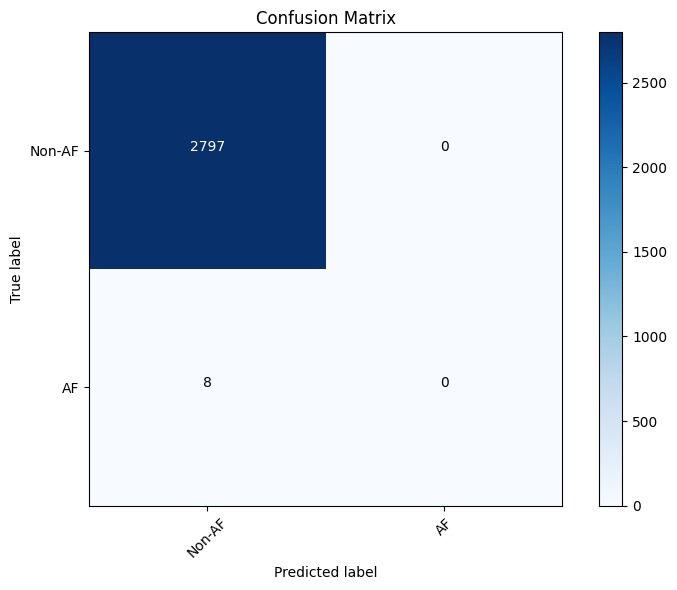

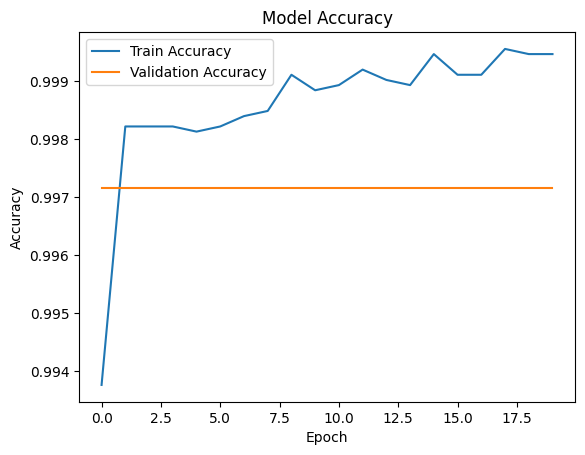

Predictions: [0 0 0 ... 0 0 0]


In [8]:
import numpy as np
import wfdb
from scipy.signal import butter, filtfilt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

records = ['06453',  # Available
           '05091',  # Corrected QRS annotations are available
           # Add more records as they become available
]

# Parameters
fs = 250  # Default sampling frequency for ECG
window_size = fs * 5  # 5 seconds

# Function to load and preprocess the data
def load_and_preprocess_record(record_name):
    record = wfdb.rdrecord(f'/content/files/{record_name}')
    ecg_signal = record.p_signal[:, 0]  # Assuming the first channel is ECG
    annotations = wfdb.rdann(f'/content/files/{record_name}', 'atr')

    # Bandpass filter design
    def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a

    # Bandpass filter application
    def bandpass_filter(data, lowcut, highcut, fs):
        b, a = butter_bandpass(lowcut, highcut, fs)
        return filtfilt(b, a, data)

    # Filter the ECG signal
    filtered_ecg = bandpass_filter(ecg_signal, 0.5, 40, fs)

    # Segment the signal into windows
    segments = [filtered_ecg[i:i + window_size] for i in range(0, len(filtered_ecg) - window_size, window_size)]

    # Create labels based on annotations
    def create_labels(segments, annotations, window_size, fs):
        labels = []
        annotation_samples = annotations.sample  # Use 'sample' instead of 'sample_indices'
        for i, segment in enumerate(segments):
            start_time = i * window_size / fs
            end_time = start_time + window_size / fs
            if any((start_time <= sample / fs < end_time) for sample in annotation_samples):
                labels.append(1)  # Atrial fibrillation
            else:
                labels.append(0)  # Non-atrial fibrillation
        return labels

    labels = create_labels(segments, annotations, window_size, fs)
    return np.array(segments), np.array(labels)

# Load data from all valid records
X_total = []
y_total = []

for record_name in records:
    print(f'Processing record: {record_name}')
    X, y = load_and_preprocess_record(record_name)
    X_total.append(X)
    y_total.append(y)

# Combine data from all records
X_total = np.concatenate(X_total, axis=0)
y_total = np.concatenate(y_total, axis=0)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.2, random_state=42)

# Define the DNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(window_size, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Reshape the input data for the model
X_train = X_train.reshape(-1, window_size, 1)
X_test = X_test.reshape(-1, window_size, 1)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# Predictions on the test set
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)

# Evaluation Metrics
print("\nClassification Report:")
print(classification_report(y_test, predicted_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Non-AF', 'AF'], rotation=45)
plt.yticks(tick_marks, ['Non-AF', 'AF'])

# Annotate the confusion matrix
thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Display some predictions
print("Predictions:", predicted_labels.flatten())